<a href="https://colab.research.google.com/github/FranArenas/RandomForest_XAI_Alumne_colaborador/blob/main/RandomForest_XAI_Fran_arenas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#Tree interpreter
!pip install treeinterpreter

# Data loading

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alumno colaborador/Data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# EDA

## Información básica

### shape

In [ ]:
df.shape

(1338, 7)

### Nulls

In [ ]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There are not NaN values on the dataset

### Número de valores

In [ ]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64



- Sex y smokers son valores binarios
- Region tiene cuatro posibles valores

In [ ]:
df['sex'].value_counts

<bound method IndexOpsMixin.value_counts of 0       female
1         male
2         male
3         male
4         male
         ...  
1333      male
1334    female
1335    female
1336    female
1337    female
Name: sex, Length: 1338, dtype: object>

In [ ]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

- Hay significativamente más no fumadores que fumadores

## Analisis

In [ ]:
df_cat = df.copy()

Primeramente categorizamos nuestros datos para un EDA más cómodo. Como no hay muchas varaibles he decidido mapearlas manualmente

In [ ]:
replace_values = {'sex' : {'male': 0, 'female' : 1},
                  'smoker': {'no' : 0, 'yes' : 1},
                  'region' : {'southeast': 0, 'northwest' : 1, 'southwest' : 2, 'northeast' : 3}}

df_cat = df_cat.replace(replace_values)

### Correlation matrix

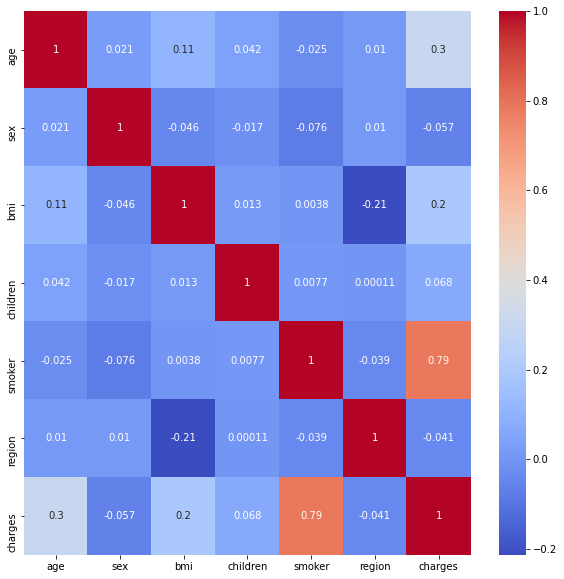

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(df_cat.corr(), cmap='coolwarm',annot=True)

- Podemos ver una fuerte correlación entre la variable objetivo (charges) y la columna smoker

### Algunas gráficas

### Charges boxplot

In [ ]:
fig = px.box(df_cat, y = 'charges')
fig.show()

Vemos que hay unos pocos outliders, en la fase de manipulación de los datos se podría tener en cuenta estos valores para tratarlos de manera que no afecten significativamente al entrenamiento

#### Smoker-age-charges

In [ ]:
fig = px.scatter(df_cat, x = 'charges', y = 'age',  color = 'smoker')
fig.show()

- Podemos observar claramente como el factor más influyente es el ser fumador o no ya que los datos se distribuyen notariamente en la parte de los fumadores (derecha) y no fumadores (izquierda)

#### Children-region-bmi-charges

In [ ]:
fig = px.scatter_3d(df_cat, x = 'children', y = 'region', z = 'bmi',  color = 'charges')
fig.show()

- Se puede apreciar que la única variable que afecta de manera apreciable (aunque no demasiado) es bmi (indice de masa corporal) representada en el eje y ya que a más altura del gráfico se puede observar un pequeño incremento de colores claros que representan un mayor coste del seguro (variable charges).
Esto coincide con el valor encontrado en la matriz de correlación

## Conclusiones sobbre nuestros datos

- Los datos no presentan valores no válidos
- El dataset presenta unos pocos outliders en la variable target
- La varaible smoker es la que más influye con diferencia
- Las varibles age y bmi influyen sobre el coste del seguro pero bastante menos que smoker
- Las otras variables no afectan de manera excesivamente significante

# Random forest

## Preparación de conjuntos de datos

In [ ]:
# Herramientas para separar datos y tunear el modelo
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
#Modelo
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df_mod = df_cat.copy()

Separamos en conjunto de test, conjunto de entrenamiento y variable objetivo

In [ ]:
#Variable objetivo
y = df_mod['charges']
X = df_mod.drop('charges', axis = 1)
#Train test spkit
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## Eliminamos posibles outliders del conjunto de entrenamiento 
- Elegimos la franja >45k basándosnos en el boxplot

In [ ]:
y_train = y_train.reset_index()
X_train = X_train.reset_index()

y_train.drop('index', axis = 1, inplace = True)
X_train.drop('index', axis = 1, inplace = True)

In [ ]:
X_train.drop(X_train.iloc[y_train[y_train['charges'] > 45000].index].index, inplace = True)
y_train.drop(y_train[y_train['charges'] > 45000].index, inplace = True)

In [ ]:
y_train.shape[0] == X_train.shape[0]

True

### Escalado de los datos

In [ ]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
X_train = st.fit_transform(X_train)
X_test = st.transform(X_test)

## Creamos el modelo

In [ ]:
import time

In [ ]:
my_forest = RandomForestRegressor(random_state= 382763)
my_grid = { 
    'n_estimators': [100, 200, 500,1000,2000,3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9], 
    'ccp_alpha': np.logspace(0, 1, 50),
    'max_samples': [x for x in range(5,21)], 
}

grid_forest = RandomizedSearchCV(my_forest,my_grid, scoring = 'r2', cv = 100)

start = time.time()
grid_forest.fit(X_train, np.ravel(y_train))
end = time.time()

print("Training time: {}".format(end-start))

Training time: 1565.5078978538513


In [ ]:
grid_forest.best_params_

{'ccp_alpha': 4.941713361323834,
 'max_depth': 6,
 'max_features': 'auto',
 'max_samples': 19,
 'n_estimators': 500}

## Evaluamos el modelo

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
prediction = grid_forest.best_estimator_.predict(X_test)


mae = mean_absolute_error(prediction, y_test)
mse = mean_squared_error(prediction, y_test)
r2 = r2_score(prediction, y_test)
score = grid_forest.best_estimator_.score(X_test,y_test)

print("Mean absolute error: {}".format(mae))
print("Mean squared error: {}".format(mse))
print("r2 score: {}".format(r2))
print("Score: {}".format(score))


Mean absolute error: 4001.6310981234574
Mean squared error: 37174188.72047647
r2 score: 0.5024596614895368
Score: 0.7659218699385701


# Interpretación del modelo

In [ ]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(grid_forest.best_estimator_, X_test)

In [ ]:
y_test.iloc[2]

20709.02034

In [ ]:
for i in range(3):
    print("Instance", i)
    print("Predicted value: {}".format(prediction[i][0]))
    print("Real value: {}".format(y_test.iloc[i]))
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 df.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*40)

Instance 0
Predicted value: 7185.533698381331
Real value: 4646.759
Bias (trainset mean) 12359.596379103265
Feature contributions:
smoker -3536.83
age -1214.32
children -305.59
bmi -125.4
region 24.98
sex -16.9
----------------------------------------
Instance 1
Predicted value: 26192.208941410023
Real value: 26926.5144
Bias (trainset mean) 12359.596379103265
Feature contributions:
smoker 14609.73
bmi -3219.42
age 1897.37
region 355.72
sex 97.33
children 91.89
----------------------------------------
Instance 2
Predicted value: 14431.455166551665
Real value: 20709.02034
Bias (trainset mean) 12359.596379103265
Feature contributions:
age 4390.69
smoker -3475.87
bmi 1021.47
region 372.89
children -221.3
sex -16.03
----------------------------------------


In [ ]:
def explainable_plot(index, contributions, bias):
  values = np.insert(contributions[index],0,bias[index])


  for i in range(1,len(values)):
    values[i] += values[i-1]

  names = np.append(["bias"], df.columns[:-1])

  data_dict = {"Features" : names, "Charge": values}
  df_px = pd.DataFrame(data = data_dict)
  
  fig = px.line(df_px, y = "Charge", x = "Features", title= "Explainable value for {} sample".format(index))

  fig.show()

In [ ]:
explainable_plot(2,contributions, bias)